# Figure 2

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os,sys
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import scipy.sparse
import anndata
import seaborn as sns
import scvelo as scv

import milopy.core as milo
import milopy.plot as milopl

In [18]:
figdir = "/home/jovyan/mount/gdrive/Pan_fetal/writing/ms_figures/draft_panels/Fig2_myeloid_lymphoid/assemble_fig2/"
if os.path.exists(figdir):
    sc.settings.figdir = figdir
    scv.settings.figdir = figdir
else:
    os.mkdir(figdir)
    sc.settings.figdir = figdir
    scv.settings.figdir = figdir

In [4]:
## r2py setup
import anndata2ri
import rpy2.rinterface_lib.callbacks
import logging
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

anndata2ri.activate()

In [5]:
%load_ext rpy2.ipython


In [6]:
%%R
library(tidyverse)
library(reshape2)
library(patchwork)

remove_x_axis <- function(){
  theme(axis.text.x = element_blank(), axis.ticks.x = element_blank(), axis.title.x = element_blank())  
}

remove_y_axis <- function(){
  theme(axis.text.y = element_blank(), axis.ticks.y = element_blank(), axis.title.y = element_blank())  
}

In [7]:
## Load organ color palette
org_colors = pd.read_csv("../metadata/organ_colors.csv", index_col=0)

In [8]:
%%R -i org_colors
org_palette <- setNames(org_colors$color, rownames(org_colors))
org_palette

       YS        LI        BM        TH        SP       MLN        SK        GU 
"#0173b2" "#de8f05" "#029e73" "#d55e00" "#cc78bc" "#ca9161" "#fbafe4" "#949494" 
       KI 
"#ece133" 


### Load dataframes for plotting

In [200]:
mye_milo_time = pd.read_csv('/nfs/team205/ed6/data/Fetal_immune/milo_outs/MYELOID_V2_v2/milo_beeswarm_plot_data.MYELOID_V2.csv', index_col=0)
mye_milo_organ = pd.read_csv('/nfs/team205/ed6/data/Fetal_immune/milo_organ_outs/MYELOID_V2/milo_heatmap_plot_data.MYELOID_V2.csv', index_col=0)
mye_adult_heatmap = pd.read_csv('/nfs/team205/ed6/data/Fetal_immune/panimmune_MYELOID_query.mapped2MYELOID_V2.confusion_table.csv', index_col=0)

lym_milo_time = pd.read_csv('/nfs/team205/ed6/data/Fetal_immune/milo_outs/LYMPHOID_v2/milo_beeswarm_plot_data.LYMPHOID.csv', index_col=0)
lym_milo_organ = pd.read_csv('/nfs/team205/ed6/data/Fetal_immune/milo_organ_outs/LYMPHOID/milo_heatmap_plot_data.LYMPHOID.csv', index_col=0)
lym_adult_heatmap = pd.read_csv('/nfs/team205/ed6/data/Fetal_immune/panimmune_LYMPHOID_query.mapped2LYMPHOID.confusion_table.csv', index_col=0)


In [201]:
## Read full annotation
data_dir = '/nfs/team205/ed6/data/Fetal_immune/'
anno_obs = pd.read_csv(data_dir + "PAN.A01.v01.entire_data_normalised_log.20210429.full_obs.annotated.clean.csv", index_col=0)

In [202]:
## Read annotation groupings
import json
with open('../metadata/anno_groups.json', 'r') as json_file:
    anno_groups_dict = json.load(json_file)

## Define annotation groupings / ordering

In [12]:
# anno_obs_mye = anno_obs[anno_obs.anno_lvl_2_final_clean.isin(anno_groups_dict["MYELOID"])].copy()
# anno_obs_lym = anno_obs[anno_obs.anno_lvl_2_final_clean.isin(anno_groups_dict['ILC'] + anno_groups_dict['B CELLS'] + anno_groups_dict['NK/T CELLS'])].copy()

In [13]:
# anno_group_myeloid = {
#     "Progenitors":['CMP','DC_PROGENITOR','GMP','MOP','MYELOCYTE','PROMONOCYTE','PROMYELOCYTE'],
#     "Granulocytes":['NEUTROPHIL', 'MAST_CELL', 'EOSINOPHIL_BASOPHIL'],
#     'DCs':[x for x in anno_obs_mye.anno_lvl_2_final_clean.unique() if "DC" in x],
#     "Mono":[x for x in anno_obs_mye.anno_lvl_2_final_clean.unique() if x.startswith("MONO")],
#     "MACs":[x for x in anno_obs_mye.anno_lvl_2_final_clean.unique() if "ACROPHAGE" in x or "MICROGLIA" in x]
#     }

# anno_group_myeloid['low quality'] = [x for x in anno_obs_mye.anno_lvl_2_final_clean.unique() if x not in sum(anno_group_myeloid.values(),[])]
# anno_group_myeloid_rev = {x:g for g,a in anno_group_myeloid.items() for x in a}

# # ## Exclude low quality
# # anno_group_myeloid_rev = {k:("low quality" if k in anno_groups_dict['OTHER'] else v) for k,v in anno_group_myeloid_rev.items()}
# # anno_group_myeloid = dict()
# # for k,v in anno_group_myeloid_rev.items():
# #     if v not in anno_group_myeloid.keys(): 
# #         anno_group_myeloid[v] = []
# #     anno_group_myeloid[v].append(k)

In [14]:
# ## Add annotation grouping
# anno_group_lymphoid = {
#     "NK cells":[x for x in anno_obs_lym.anno_lvl_2_final_clean.unique() if x.endswith("NK")],
#     "ILCs":[x for x in anno_obs_lym.anno_lvl_2_final_clean.unique() if x.startswith("ILC")],
#     "B cells":[x for x in anno_obs_lym.anno_lvl_2_final_clean.unique() if x.endswith("B") or x=="B1"],
#     "T cells":[x for x in anno_obs_lym.anno_lvl_2_final_clean.unique() if x.endswith("T") or x=="ABT(ENTRY)" or x=="CD8AA"],
#    "Progenitors":anno_groups_dict["PROGENITORS"]
#     }

# anno_group_lymphoid['l'] = [x for x in anno_obs_lym.anno_lvl_2_final_clean.unique() if x not in sum(anno_group_lymphoid.values(),[])]
# anno_group_lymphoid_rev = {x:g for g,a in anno_group_lymphoid.items() for x in a}

# anno_group_lymphoid
# # ## Exclude low quality
# # anno_group_lymphoid_rev = {k:("l" if k in anno_groups_dict['l'] else v) for k,v in anno_group_myeloid_rev.items()}
# # anno_group_myeloid = dict()
# # for k,v in anno_group_myeloid_rev.items():
# #     if v not in anno_group_myeloid.keys(): 
# #         anno_group_myeloid[v] = []
# #     anno_group_myeloid[v].append(k)

In [275]:
anno_group_lymphoid = {
    'NK cells': ['NK', 'CYCLING_NK'],
    'ILCs': ['ILC2','ILC3','CYCLING_ILC'],
    'B cells': [
      'PRE_PRO_B',
          'PRO_B',
        'LATE_PRO_B',
        'LARGE_PRE_B',
        'SMALL_PRE_B',
    'IMMATURE_B',
      'MATURE_B',
      'B1',
  'CYCLING_B',
      'PLASMA_B'],
    'Developing T cells': [              
                'DN(early)_T',
                'DN(Q)_T',
                'DN(P)_T',
                'DP(P)_T',
                'DP(Q)_T',
                'ABT(ENTRY)'
               ],
    'Conventional SP T cells':['CYCLING_T',
                'CD4+T',
                'CD8+T',
                               'TREG'
    ],
 'Unconventional T cells': [ 'TYPE_1_INNATE_T', 'TYPE_3_INNATE_T','CD8AA'],
    "low quality":['HIGH_MITO','DOUBLET_ERY_B']}

anno_group_lymphoid_rev = {x:g for g,a in anno_group_lymphoid.items() for x in a}

In [276]:
anno_group_myeloid = {
    'Progenitors': ['HSC_MPP','CMP',
  'GMP',
  'MOP',
    
    'LMPP_MLP',
    'MEMP',
    'MEP',
    'CYCLING_MEMP',
    'CYCLING_MPP',
    
                    'PROMONOCYTE',
                
  'PROMYELOCYTE',
                       'MYELOCYTE',
    'DC_PROGENITOR',
],
    
#     DC1, DC2, DC3, cycling DC2 and cycling DC3 and then migratory DC. Then put pDCs, cycling pDC
 'DCs': [
  'AS_DC',
     'PRE_DC2',
  'DC1',
  'DC2',
    "DC3",
     'CYCLING_DC',
  'MIGRATORY_DC',
       'PDC',
  'CYCLING_PDC',
  ],
 'Granulocytes': ['NEUTROPHIL', 'MAST_CELL', 'EOSINOPHIL_BASOPHIL'],
 'Mono': ['MONOCYTE_I_CXCR4', 'MONOCYTE_II_CCR2', 'MONOCYTE_III_IL1B'],
 'MACs': ['MACROPHAGE_PROLIFERATING',
  'MACROPHAGE_MHCII_HIGH',
  'MACROPHAGE_LYVE1_HIGH',
#   'MACROPHAGE_PERI',
#   'MACROPHAGE_ERY',
  'MACROPHAGE_IRON_RECYCLING',
  'MACROPHAGE_KUPFFER_LIKE',
  'MACROPHAGE_TREM2',
           'LANGERHANS_CELLS',
            'OSTEOCLAST'
         ],
 'low quality': ['FIBROBLAST_XVII',
  'YS_ERY',
  'CYCLING_YS_ERY',
  'YS_STROMA',
  'DEVELOPING_NEPHRON_I',
  'DEVELOPING_NEPHRON_II',
           'EARLY_MK',
    'LOW_QUALITY_MACROPHAGE',
           'DOUBLET_ERY_B'
          ]
}

anno_group_myeloid_rev = {x:g for g,a in anno_group_myeloid.items() for x in a}

In [205]:
organ_order = ['YS', "LI", "BM", "TH","SP", "MLN", 'SK', "KI", "GU"]

## Myeloid

### Embedding

In [206]:
data_dir="/nfs/team205/ed6/data/Fetal_immune/"
timestamp="20210429"
split="MYELOID_V2"

In [207]:
data_dir="/nfs/team205/ed6/data/Fetal_immune/"
timestamp="20210429"

In [161]:
adata = sc.read_h5ad(data_dir + 'PAN.A01.v01.entire_data_normalised_log.{t}.{s}.embedding.h5ad'.format(t=timestamp, s=split), backed="r")
adata.var_names_make_unique()

In [208]:
anno_obs = pd.read_csv(data_dir + "PAN.A01.v01.entire_data_normalised_log.20210429.full_obs.annotated.clean.csv", index_col=0)
anno_obs_mye = anno_obs.loc[adata.obs_names[adata.obs_names.isin(anno_obs.index)]].copy()

In [209]:
anno_obs = anno_obs_mye.copy()
anno_group = anno_group_myeloid.copy()
anno_group_rev = anno_group_myeloid_rev.copy()

org_count_df = anno_obs_mye.groupby(["organ", "anno_lvl_2_final_clean"]).count()['file'].reset_index()
org_count_df["anno_group"] = [anno_group_rev[x] if x in anno_group_rev.keys() else np.nan for x in org_count_df.anno_lvl_2_final_clean]
org_count_df["anno"] = org_count_df["anno_lvl_2_final_clean"]

age_count_df = anno_obs_mye.groupby(["age", "anno_lvl_2_final_clean"]).count()['file'].reset_index()
age_count_df["anno_group"] = [anno_group_rev[x] if x in anno_group_rev.keys() else np.nan for x in age_count_df.anno_lvl_2_final_clean]
age_count_df["anno"] = age_count_df["anno_lvl_2_final_clean"]

anno_group_order = list(anno_group.keys())
anno_order = [x for x in sum([v for v in anno_group.values()],[]) if x in anno_obs_mye.anno_lvl_2_final_clean.values]

In [84]:
adata.obs['anno_lvl_2_final_clean'] = np.nan
adata.obs.loc[adata.obs_names.isin(anno_obs_mye.index), 'anno_lvl_2_final_clean'] = anno_obs_mye.loc[adata.obs_names[adata.obs_names.isin(anno_obs_mye.index)]]['anno_lvl_2_final_clean']

In [85]:
anno_numbering = {anno_order[i]:str(i+1) for i in range(len(anno_order))}
adata.obs['anno_number'] = [anno_numbering[x] if x in anno_order else np.nan for x in adata.obs['anno_lvl_2_final_clean']]

saving figure to file /home/jovyan/mount/gdrive/Pan_fetal/writing/ms_figures/draft_panels/assemble_fig2/scvelo_MYELOID_V2_annotation_embedding.png


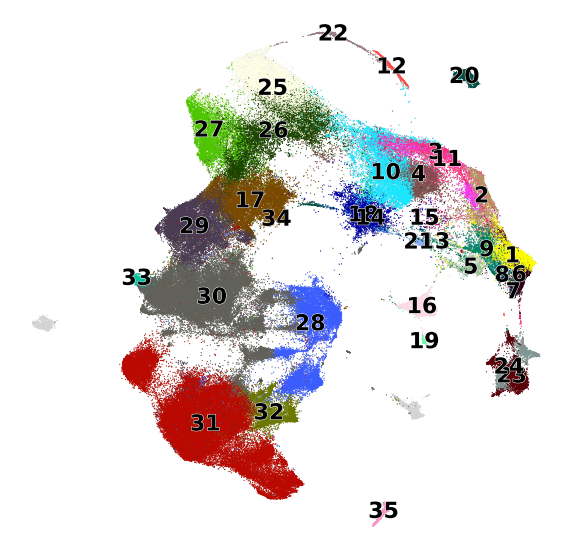

In [32]:
high_q_numbers = adata.obs['anno_number'][~adata.obs['anno_lvl_2_final_clean'].isin(anno_group_myeloid['low quality'])].unique().astype("str")
plt.rcParams['figure.figsize'] = [10,10]
scv.pl.umap(adata, color=['anno_number'], 
            title="", legend_fontsize=22, size=5,
            groups= high_q_numbers,
            save='MYELOID_V2_annotation_embedding.png'
           )

Make legend

In [34]:
color_dict = dict(zip(adata.obs['anno_number'].cat.categories, adata.uns['anno_number_colors']))
anno_order_labels = ["({n}) {a}".format(n=str(i+1),a=anno_order[i]) for i in range(len(anno_order))]
anno_number = ["{n}".format(n=str(i+1)) for i in range(len(anno_order))]

anno_order_df = pd.DataFrame([anno_order_labels, anno_order]).T
anno_order_df.columns = ['anno_order_labels', 'anno_lvl_2_final_clean']
anno_order_df['anno_number'] = [anno_numbering[x] for x in anno_order_df['anno_lvl_2_final_clean']]
anno_order_df['anno_color'] = [color_dict[x] for x in anno_order_df['anno_number']]
anno_order_df['anno_group'] = [anno_group_myeloid_rev[x] for x in anno_order_df['anno_lvl_2_final_clean']]

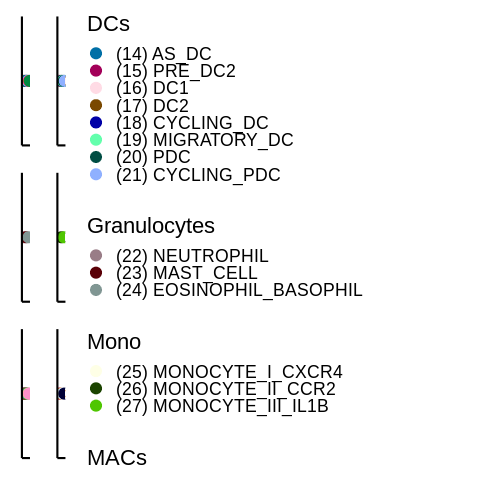

In [35]:
%%R -i anno_order_df -i figdir
library(ggpubr)
anno_order_df$anno_order_labels <- factor(anno_order_df$anno_order_labels, levels=anno_order_df$anno_order_labels)
leg_ls <- lapply(unique(anno_order_df$anno_group), function(g) {
    pl <- anno_order_df %>%
    filter(anno_group==g) %>%
    ggplot(aes(anno_order_labels, 1, color=anno_order_labels)) +
    geom_point(size=5) +
    theme_classic(base_size=22) +
    remove_x_axis() +
    remove_y_axis() +
    scale_color_manual(values=setNames(anno_order_df$anno_color, anno_order_df$anno_order_labels),
                      name=g)
#     leg <- get_legend(pl)
#     leg
    pl
    }
)

(wrap_plots(leg_ls, ncol=2) +
plot_layout(guides='collect') & 
theme(legend.justification = "left") &
guides(color=guide_legend(ncol = 1))) +
ggsave(paste0(figdir, "mye_embedding_legend.pdf"), height=15, width=12)

In [81]:
# ### Organ / age distribution

# %%R -i age_count_df -i org_count_df -i figdir -i anno_group_order -i anno_order -i organ_order -w 800 -h 1000
# library(glue)
# anno_order_labels <- glue("({1:length(anno_order)}) {anno_order}")
# anno_order_labels <- setNames(anno_order_labels, anno_order)

# ## Plot age barplot
# age_pl_df <- age_count_df %>%
#     rename(N_cells = file) %>%
#     group_by(anno) %>%
#     mutate(max_age = age[which.max(N_cells)])  %>% ## At which age there are most cells?
#     mutate(min_age = min(age[which(N_cells > 10)]))  %>%
#     ungroup() %>%
#     arrange(- max_age) %>%
# #     mutate(anno=factor(anno, levels=unique(anno))) %>%
#     mutate(anno=anno_order_labels[anno]) %>%
#     mutate(anno=factor(anno, levels=rev(anno_order_labels))) %>%
#     mutate(anno_group = factor(anno_group, levels=anno_group_order))
    
# p2 <- age_pl_df %>%
#     filter(N_cells > 10) %>%
#     ggplot(aes(anno, N_cells)) + 
#     geom_col(aes(fill=age),position="fill", width=0.8) +
#     coord_flip() +
#     facet_grid(anno_group~., space="free", scales="free") +
#     scale_fill_viridis_c() +
#     theme_bw(base_size=20) +
#     theme(strip.text.y=element_text(angle=0)) +
#     ylab("fraction of cells") + xlab("") +
#     expand_limits(y = 1.5) +
#     geom_text(data=. %>% group_by(anno) %>% 
#               summarise(N_cells=sum(N_cells), anno_group=first(anno_group)),
#               hjust=0, size=5,
#               y=1.01, aes(label=paste("N =", N_cells))
#              ) 

# ## Plot organ barplot
# org_palette <- setNames(org_colors$color, rownames(org_colors))
# org_pl_df <- org_count_df %>%
#     rename(N_cells = file) %>%
#     mutate(anno=anno_order_labels[anno]) %>%
#     mutate(anno=factor(anno, levels=levels(age_pl_df$anno))) %>%
#     mutate(anno_group = factor(anno_group, levels=anno_group_order))

# p1 <- org_pl_df %>%
#     filter(N_cells > 10) %>%
#     mutate(organ=factor(organ, levels=organ_order)) %>%
#     ggplot(aes(anno, N_cells)) + 
#     geom_col(aes(fill=organ) ,position="fill", width=0.8) +
#     coord_flip() +
#     facet_grid(anno_group~., space="free", scales="free") +
#     scale_fill_manual(values=org_palette) +
#     theme_bw(base_size=20) +
#     theme(strip.text.y=element_text(angle=0)) +
#     ylab("fraction of cells") + xlab("") +
#     theme(strip.background=element_blank(), strip.text.y = element_blank())
# #     geom_text(data=. %>% group_by(anno) %>% 
# #               summarise(N_cells=sum(N_cells), anno_group=first(anno_group)),
# #               hjust=0,
# #               y=1.01, aes(label=paste("N =", N_cells))
# #              ) +

# fig2_lym_barplots <- (p1 + (p2 + remove_y_axis())) +
# plot_layout(widths=c(1,1.2), guides="collect") &
# # (guides(fill = guide_colourbar(title.position="top", title.hjust = 0.5))) &
# (theme(legend.position="top"))

# fig2_lym_barplots +
#     ggsave(paste0(figdir, "mye_organ_age_distribution.pdf"), height=12, width=15) +
#     ggsave(paste0(figdir, "mye_organ_age_distribution.png"), height=12, width=15) 

### Milo in time beeswarm plot

In [86]:
mye_milo_time.anno_group = [anno_group_rev[x] if x in anno_order else 'NA' for x in mye_milo_time.nhood_anno]

In [87]:
anno_group_order

['Progenitors', 'DCs', 'Granulocytes', 'Mono', 'MACs', 'low quality']

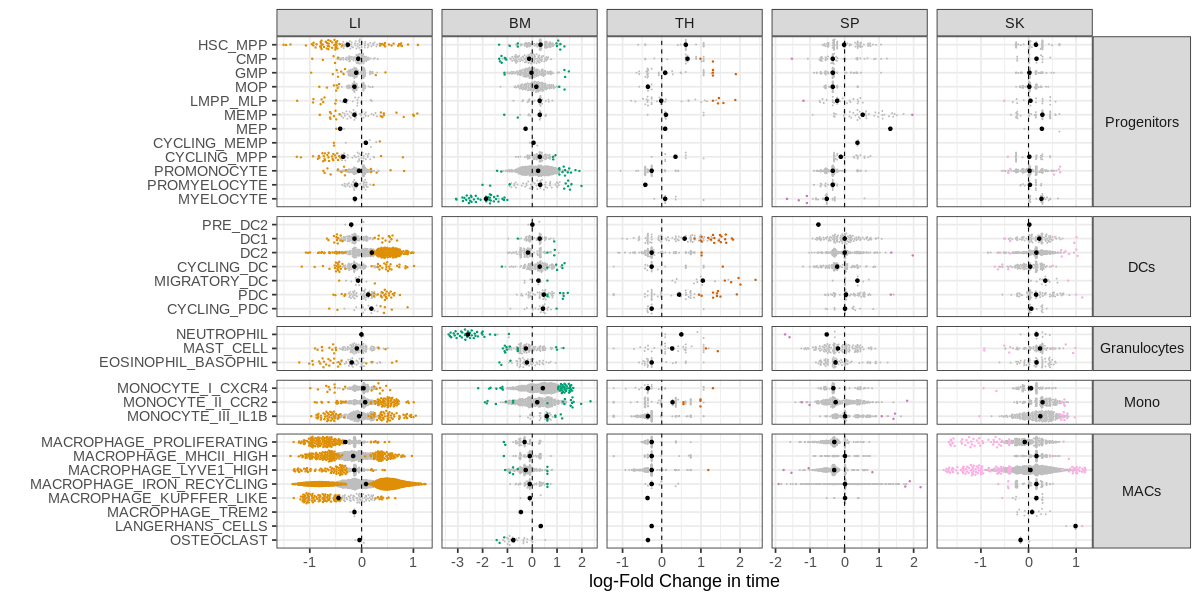

In [88]:
%%R -w 1200 -h 600 -i figdir -i mye_milo_time -i anno_order -i organ_order -i anno_group_order
library(ggbeeswarm)
alpha=0.1
set.seed(12345)

pl_df <- mye_milo_time %>%
    ## Reorder annotation names by median FC
    group_by(nhood_anno) %>%
    mutate(mean_logFC = median(logFC, na.rm=TRUE)) %>%
    ungroup() %>%
    arrange(- mean_logFC) %>%
    mutate(nhood_anno=factor(nhood_anno, levels=rev(anno_order))) %>%
    ## Calculate median per organ, to plot
    group_by(organ, nhood_anno) %>%
    mutate(mean_logFC = median(logFC, na.rm=TRUE)) %>%
    ungroup() %>%
    mutate(anno_group=factor(anno_group, levels=anno_group_order)) %>%
    mutate(organ=factor(organ, levels=organ_order)) %>%
    filter(!is.na(anno_group)) 

fig2_mye_beeswarm <- pl_df %>%
    mutate(organ_color=ifelse(SpatialFDR < alpha, as.character(organ), NA)) %>%
    filter(anno_group!='low quality') %>%
    ggplot(aes(nhood_anno, logFC)) +
    geom_quasirandom(data=. %>% filter(SpatialFDR >= alpha),size=0.3, color="grey") +
    geom_quasirandom(data=. %>% filter(SpatialFDR < alpha), size=0.5, aes(color=organ_color)) +
    geom_point(data= . %>% distinct(organ, nhood_anno, anno_group, mean_logFC), aes(x=nhood_anno, y=mean_logFC), color="black")  +
    facet_grid(anno_group~organ, scales="free", space="free_y") +
    coord_flip() +
    scale_color_manual(values=org_palette) +
    scale_fill_manual(values=org_palette) +
    guides(color="none", fill="none") +
    geom_hline(yintercept=0, linetype=2) +
    theme_bw(base_size=18) +
    xlab("") + ylab("log-Fold Change in time") +
    scale_y_continuous(breaks=seq(-3,3, by=1)) +
    theme(strip.text.y=element_text(angle=0))
    
fig2_mye_beeswarm
#     ggsave(paste0(figdir, "milo_results_overview_beeswarm.pdf"), width=15, height=15) +
#     ggsave(paste0(figdir, "milo_results_overview_beeswarm.png"), width=15, height=15)

In [89]:
org_age_range  = anno_obs[['organ', "age"]].drop_duplicates()

In [90]:
%%R -i org_age_range -w 1000 -h 200 -i organ_order
fig2_mye_agebar <- org_age_range %>%
    filter(organ %in% mye_milo_time$organ) %>%
    mutate(organ=factor(organ, levels=organ_order)) %>%
    group_by(organ) %>%
    mutate(max_age=paste0(max(age), " PCW"), 
           min_age=paste0(min(age), " PCW")) %>%
    mutate(y=1) %>%
    ggplot(aes( age, y, color=organ)) +
    geom_point(size=3) +
    geom_line(size=2) +
    geom_text(data=. %>% group_by(organ) %>% filter(age==min(age)), 
              aes(label=min_age), angle=45,
              vjust = 1.2, 
              hjust = 1.1, nudge_x = -0.05, color='black') +
    geom_text(data=. %>% group_by(organ) %>% filter(age==max(age)), 
              aes(label=max_age), angle=45,
              vjust = 1.2,  
              hjust = 1.1, nudge_x = -0.05, color='black') +
    facet_grid(.~organ) +
    scale_color_manual(values=org_palette) +
    theme_classic(base_size=18) +
     expand_limits(x = c(3,20)) +
    remove_y_axis() + remove_x_axis() + 
    guides(color='none') +
    xlab("") + ylab("log-Fold Change in time") +
    theme(strip.text.y=element_text(angle=0), axis.line=element_blank(), 
          strip.background=element_blank(), strip.text=element_blank())

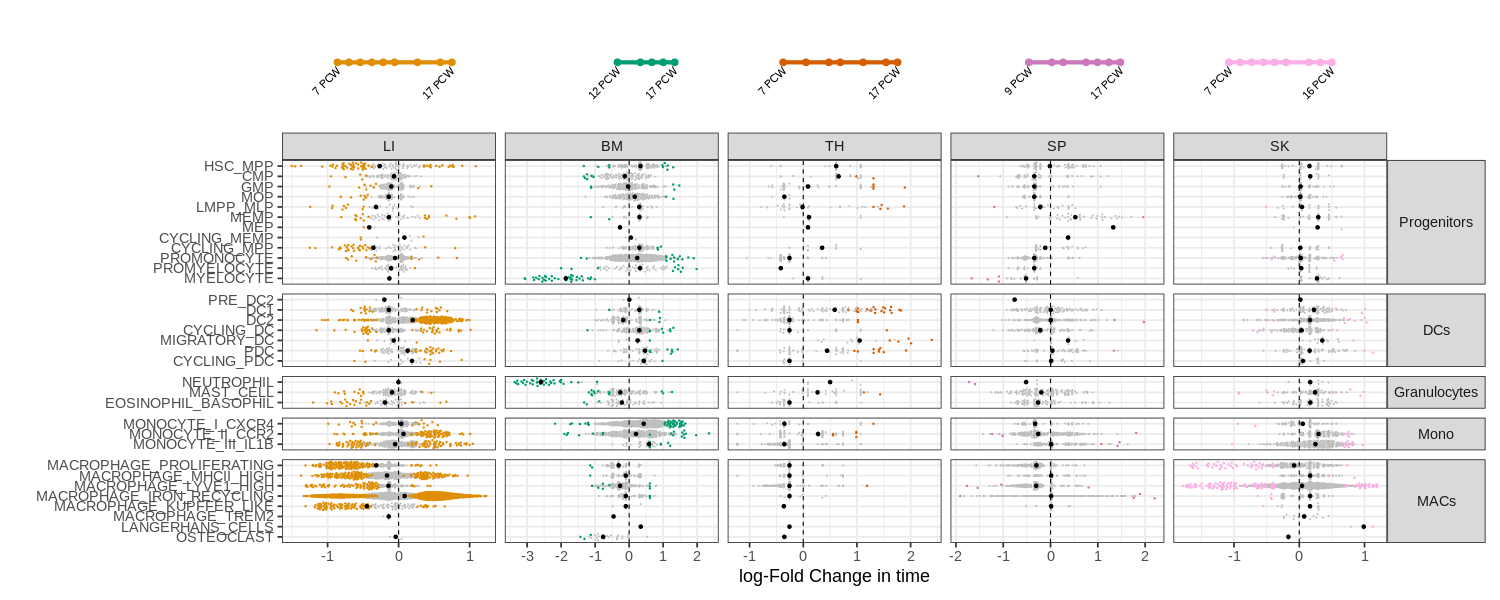

In [91]:
%%R -w 1500 -h 600
layout <- "
AAAAA
BBBBB
BBBBB
BBBBB
BBBBB
"

fig2_milo_age  <- fig2_mye_agebar + 
    fig2_mye_beeswarm +
    plot_layout(design=layout) 

fig2_milo_age +
ggsave(paste0(figdir, "milo_results_overview_beeswarm.pdf"), width=14, height=10) +
ggsave(paste0(figdir, "milo_results_overview_beeswarm.png"), width=14, height=10)


### Adult vs fetal

In [210]:
anno_group_rev = anno_group_myeloid_rev.copy()

In [241]:
q_df = mye_adult_heatmap.copy()

## Add lines for missing cell types
missing_anno_df = pd.DataFrame([x for x in anno_order if x not in q_df.predicted_anno.values], columns=['predicted_anno'])
q_df = pd.concat([q_df, missing_anno_df])

q_df['predicted_anno_group'] = [anno_group_rev[x] if x in anno_order else 'low_confidence' if x=='low_confidence' else 'NA' for x in q_df['predicted_anno']]

In [242]:
## Exclude rogue labels
keep_query_cts = q_df.annotation_query.value_counts().index[q_df.annotation_query.value_counts() > 10]
keep_query_cts

Index(['Classical monocytes', 'Alveolar macrophages',
       'Intermediate macrophages', 'Erythrophagocytic macrophages',
       'Nonclassical monocytes', 'DC2', 'Cycling', 'migDC', 'DC1',
       'Intestinal macrophages'],
      dtype='object')

`summarise()` has grouped output by 'predicted_anno', 'annotation_query', 'annotation_query_group', 'predicted_anno_group'. You can override using the `.groups` argument.


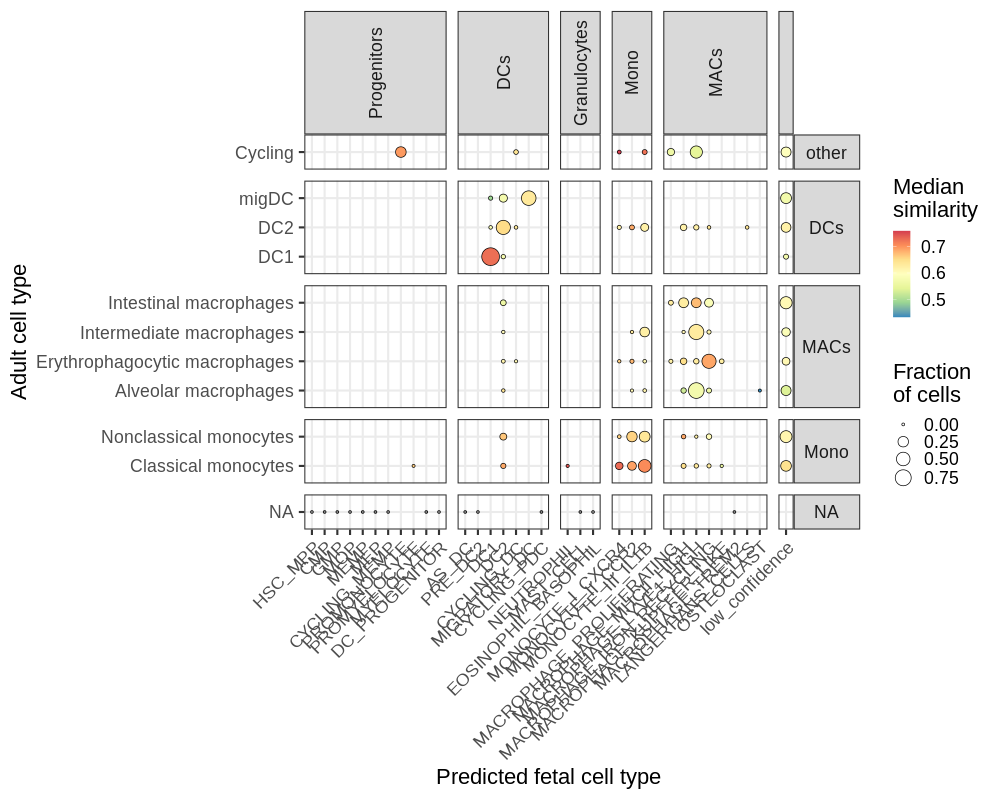

In [258]:
%%R -i q_df -h 800 -w 1000 -i figdir -i keep_query_cts -i anno_order -i anno_group_order
q_df %>%
    filter((annotation_query %in% keep_query_cts) | (is.na(annotation_query))) %>%
    group_by(annotation_query) %>%
    mutate(tot_cells=n()) %>%
    ungroup() %>%
    group_by(predicted_anno, annotation_query, annotation_query_group, predicted_anno_group) %>%
    summarise(frac_cells=n()/tot_cells, median_sim_score=median(min_distance2pred)) %>%
    ungroup() %>%
    filter(predicted_anno_group != 'low quality' & predicted_anno_group != 'NA') %>%
    mutate(annotation_query_group=factor(annotation_query_group, levels=unique(annotation_query_group))) %>%
    mutate(predicted_anno_group = ifelse(predicted_anno_group=="low_confidence", '', predicted_anno_group)) %>%
    mutate(predicted_anno_group=factor(predicted_anno_group, levels=c(anno_group_order, ''))) %>%
    mutate(predicted_anno=factor(predicted_anno, levels=c(anno_order, 'low_confidence'))) %>%
    distinct() %>%
     mutate(frac_cells = ifelse(is.na(annotation_query), 0, frac_cells)) %>%
   ggplot(aes(predicted_anno, annotation_query)) +
    scale_size(range=c(1,8), name="Fraction\nof cells") +
    geom_point(aes(size=frac_cells, fill=median_sim_score), shape=21) +
    scale_fill_distiller(palette="Spectral", direction=-1, name='Median\nsimilarity',
                        ) +
#     scale_fill_viridis_c(option='magma', name='Median\nsimilarity') +
    facet_grid(annotation_query_group~predicted_anno_group, space="free", scales='free') +
    xlab("Predicted fetal cell type") + ylab("Adult cell type") +
    theme_bw(base_size=22) +
    theme(axis.text.x=element_text(angle=45, hjust=1),
          strip.text.y=element_text(angle=0), strip.text.x=element_text(angle=90)
         ) +
    ggsave(paste0(figdir, "adult_confusion_similarity_dotplot.pdf"), width=17, height=9)

---
## Lymphoid

### Embedding

In [277]:
data_dir="/nfs/team205/ed6/data/Fetal_immune/"
timestamp="20210429"
split="LYMPHOID"

In [278]:
data_dir="/nfs/team205/ed6/data/Fetal_immune/"
timestamp="20210429"

In [94]:
adata = sc.read_h5ad(data_dir + 'PAN.A01.v01.entire_data_normalised_log.{t}.{s}.embedding.h5ad'.format(t=timestamp, s=split), backed="r")
adata.var_names_make_unique()

In [279]:
anno_obs = pd.read_csv(data_dir + "PAN.A01.v01.entire_data_normalised_log.20210429.full_obs.annotated.clean.csv", index_col=0)
anno_obs_lym = anno_obs.loc[adata.obs_names[adata.obs_names.isin(anno_obs.index)]].copy()

In [280]:
anno_obs = anno_obs_lym.copy()
anno_group = anno_group_lymphoid.copy()
anno_group_rev = anno_group_lymphoid_rev.copy()

org_count_df = anno_obs_lym.groupby(["organ", "anno_lvl_2_final_clean"]).count()['file'].reset_index()
org_count_df["anno_group"] = [anno_group_rev[x] if x in anno_group_rev.keys() else np.nan for x in org_count_df.anno_lvl_2_final_clean]
org_count_df["anno"] = org_count_df["anno_lvl_2_final_clean"]

age_count_df = anno_obs_lym.groupby(["age", "anno_lvl_2_final_clean"]).count()['file'].reset_index()
age_count_df["anno_group"] = [anno_group_rev[x] if x in anno_group_rev.keys() else np.nan for x in age_count_df.anno_lvl_2_final_clean]
age_count_df["anno"] = age_count_df["anno_lvl_2_final_clean"]

anno_group_order = list(anno_group.keys())
anno_order = sum([v for v in anno_group.values()],[])

In [97]:
adata.obs['anno_lvl_2_final_clean'] = np.nan
adata.obs.loc[adata.obs_names.isin(anno_obs_lym.index), 'anno_lvl_2_final_clean'] = anno_obs_lym.loc[adata.obs_names[adata.obs_names.isin(anno_obs_lym.index)]]['anno_lvl_2_final_clean']

In [98]:
anno_numbering = {anno_order[i]:str(i+1) for i in range(len(anno_order))}
adata.obs['anno_number'] = [anno_numbering[x] if x in anno_order else np.nan for x in adata.obs['anno_lvl_2_final_clean']]

saving figure to file /home/jovyan/mount/gdrive/Pan_fetal/writing/ms_figures/draft_panels/Fig2_myeloid_lymphoid/assemble_fig2/scvelo_LYMPHOID_annotation_embedding.png


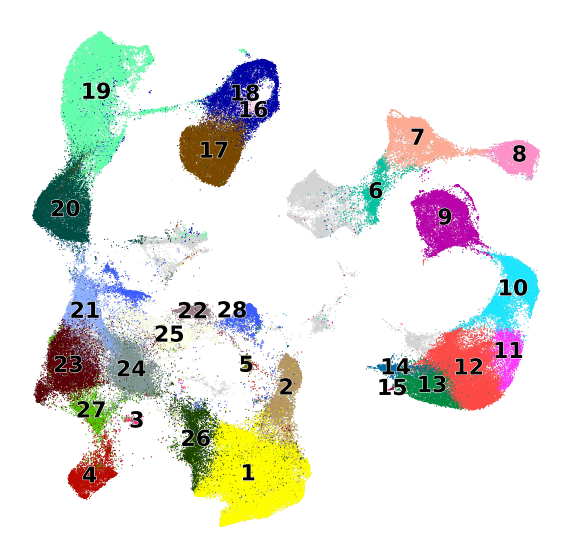

In [99]:
high_q_numbers = adata.obs['anno_number'][~adata.obs['anno_lvl_2_final_clean'].isin(anno_group_lymphoid['low quality'])].unique().astype("str")

plt.rcParams['figure.figsize'] = [10,10]
scv.pl.umap(adata, color=['anno_number'], 
            title="", legend_fontsize=22, size=5,
            groups=high_q_numbers,
            save='LYMPHOID_annotation_embedding.png'
           )

Make legend

In [81]:
color_dict = dict(zip(adata.obs['anno_number'].cat.categories, adata.uns['anno_number_colors']))
anno_order_labels = ["({n}) {a}".format(n=str(i+1),a=anno_order[i]) for i in range(len(anno_order))]
anno_number = ["{n}".format(n=str(i+1)) for i in range(len(anno_order))]

anno_order_df = pd.DataFrame([anno_order_labels, anno_order]).T
anno_order_df.columns = ['anno_order_labels', 'anno_lvl_2_final_clean']
anno_order_df['anno_number'] = [anno_numbering[x] for x in anno_order_df['anno_lvl_2_final_clean']]
anno_order_df['anno_color'] = [color_dict[x] for x in anno_order_df['anno_number']]
anno_order_df['anno_group'] = [anno_group_lymphoid_rev[x] for x in anno_order_df['anno_lvl_2_final_clean']]

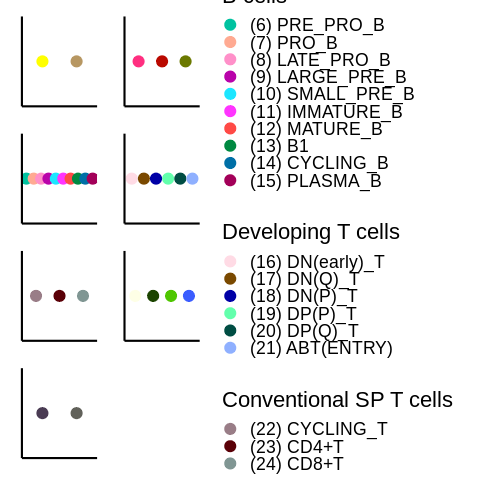

In [82]:
%%R -i anno_order_df 
library(ggpubr)
anno_order_df$anno_order_labels <- factor(anno_order_df$anno_order_labels, levels=anno_order_df$anno_order_labels)
leg_ls <- lapply(unique(anno_order_df$anno_group), function(g) {
    pl <- anno_order_df %>%
    filter(anno_group==g) %>%
    ggplot(aes(anno_order_labels, 1, color=anno_order_labels)) +
    geom_point(size=5) +
    theme_classic(base_size=22) +
    remove_x_axis() +
    remove_y_axis() +
    scale_color_manual(values=setNames(anno_order_df$anno_color, anno_order_df$anno_order_labels),
                      name=g)
#     leg <- get_legend(pl)
#     leg
    pl
    }
)

(wrap_plots(leg_ls, ncol=2) +
plot_layout(guides='collect') & 
theme(legend.justification = "left") &
guides(color=guide_legend(ncol = 1))) +
ggsave(paste0(figdir, "lym_embedding_legend.pdf"), height=14, width=12)

### Other embeddings

#### Progenitors

In [113]:
split="HSC_PROGENITORS"

In [114]:
adata = sc.read_h5ad(data_dir + 'PAN.A01.v01.entire_data_normalised_log.{t}.{s}.embedding.h5ad'.format(t=timestamp, s=split), backed="r")
adata.var_names_make_unique()

In [115]:
anno_obs = pd.read_csv(data_dir + "PAN.A01.v01.entire_data_normalised_log.20210429.full_obs.annotated.clean.csv", index_col=0)
anno_obs_lym = anno_obs.loc[adata.obs_names[adata.obs_names.isin(anno_obs.index)]].copy()

In [116]:
anno_obs = anno_obs_lym.copy()
anno_order = list(anno_obs_lym['anno_lvl_2_final_clean'].unique())
anno_order.sort()
anno_group = {split:anno_order}

In [117]:
adata.obs['anno_lvl_2_final_clean'] = np.nan
adata.obs.loc[adata.obs_names.isin(anno_obs_lym.index), 'anno_lvl_2_final_clean'] = anno_obs_lym.loc[adata.obs_names[adata.obs_names.isin(anno_obs_lym.index)]]['anno_lvl_2_final_clean']

In [118]:
anno_numbering = {anno_order[i]:str(i+1) for i in range(len(anno_order))}
adata.obs['anno_number'] = [anno_numbering[x] if x in anno_order else np.nan for x in adata.obs['anno_lvl_2_final_clean']]

saving figure to file /home/jovyan/mount/gdrive/Pan_fetal/writing/ms_figures/draft_panels/assemble_fig2/scvelo_HSC_PROGENITORS_annotation_embedding.png


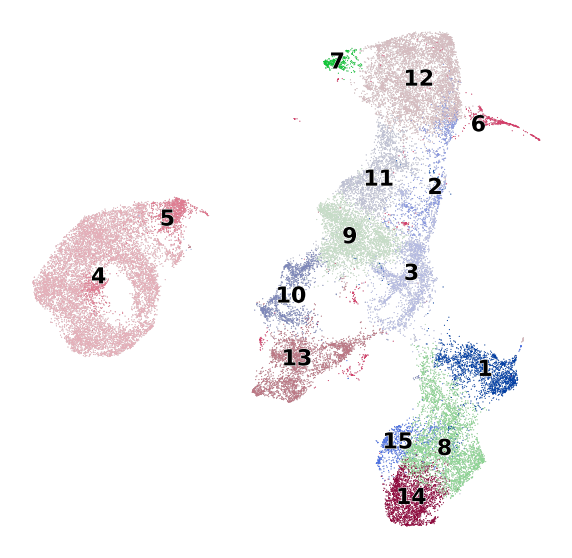

In [119]:
# high_q_numbers = adata.obs['anno_number'][~adata.obs['anno_lvl_2_final_clean'].isin(anno_group_lymphoid['low quality'])].unique().astype("str")

plt.rcParams['figure.figsize'] = [10,10]
scv.pl.umap(adata, color=['anno_number'], 
            title="", legend_fontsize=22, size=5,
#             groups=high_q_numbers,
            save='{s}_annotation_embedding.png'.format(s=split)
           )

Make legend

In [120]:
color_dict = dict(zip(adata.obs['anno_number'].cat.categories, adata.uns['anno_number_colors']))
anno_order_labels = ["({n}) {a}".format(n=str(i+1),a=anno_order[i]) for i in range(len(anno_order))]
anno_number = ["{n}".format(n=str(i+1)) for i in range(len(anno_order))]

anno_order_df = pd.DataFrame([anno_order_labels, anno_order]).T
anno_order_df.columns = ['anno_order_labels', 'anno_lvl_2_final_clean']
anno_order_df['anno_number'] = [anno_numbering[x] for x in anno_order_df['anno_lvl_2_final_clean']]
anno_order_df['anno_color'] = [color_dict[x] for x in anno_order_df['anno_number']]
anno_order_df['anno_group'] = split

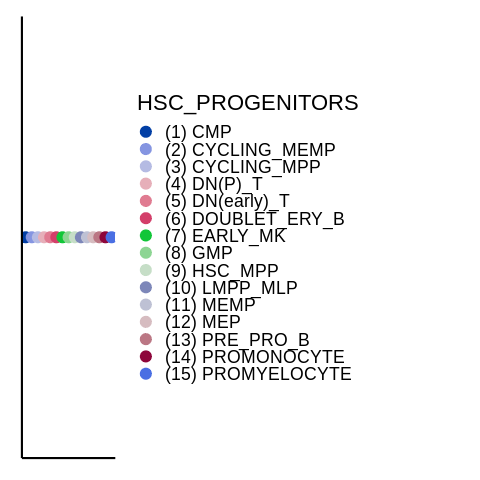

In [121]:
%%R -i anno_order_df 
library(ggpubr)
anno_order_df$anno_order_labels <- factor(anno_order_df$anno_order_labels, levels=anno_order_df$anno_order_labels)
leg_ls <- lapply(unique(anno_order_df$anno_group), function(g) {
    pl <- anno_order_df %>%
    filter(anno_group==g) %>%
    ggplot(aes(anno_order_labels, 1, color=anno_order_labels)) +
    geom_point(size=5) +
    theme_classic(base_size=22) +
    remove_x_axis() +
    remove_y_axis() +
    scale_color_manual(values=setNames(anno_order_df$anno_color, anno_order_df$anno_order_labels),
                      name=g)
#     leg <- get_legend(pl)
#     leg
    pl
    }
)

(wrap_plots(leg_ls, ncol=2) +
plot_layout(guides='collect') & 
theme(legend.justification = "left") &
guides(color=guide_legend(ncol = 1))) +
ggsave(paste0(figdir, "progenitor_embedding_legend.pdf"), height=14, width=12)

#### NK/T cells

In [187]:
split="NKT"

In [188]:
adata = sc.read_h5ad(data_dir + 'PAN.A01.v01.entire_data_normalised_log.{t}.{s}.embedding.h5ad'.format(t=timestamp, s=split), backed="r")
adata.var_names_make_unique()

In [189]:
anno_obs = pd.read_csv(data_dir + "PAN.A01.v01.entire_data_normalised_log.20210429.full_obs.annotated.clean.csv", index_col=0)
anno_obs_lym = anno_obs.loc[adata.obs_names[adata.obs_names.isin(anno_obs.index)]].copy()

In [190]:
anno_obs = anno_obs_lym.copy()
anno_order = sum([anno_group_lymphoid[x] for x in ['NK cells', 'ILCs', 'Developing T cells', 'Conventional SP T cells', 'Unconventional T cells']], [])
# keep_annos = 
anno_order.sort()
anno_group = {split:anno_order}

In [191]:
adata.obs['anno_lvl_2_final_clean'] = np.nan
adata.obs.loc[adata.obs_names.isin(anno_obs_lym.index), 'anno_lvl_2_final_clean'] = anno_obs_lym.loc[adata.obs_names[adata.obs_names.isin(anno_obs_lym.index)]]['anno_lvl_2_final_clean']

In [192]:
anno_numbering = {anno_order[i]:str(i+1) for i in range(len(anno_order))}
adata.obs['anno_number'] = [anno_numbering[x] if x in anno_order else np.nan for x in adata.obs['anno_lvl_2_final_clean']]

saving figure to file /home/jovyan/mount/gdrive/Pan_fetal/writing/ms_figures/draft_panels/assemble_fig2/scvelo_NKT_annotation_embedding.png


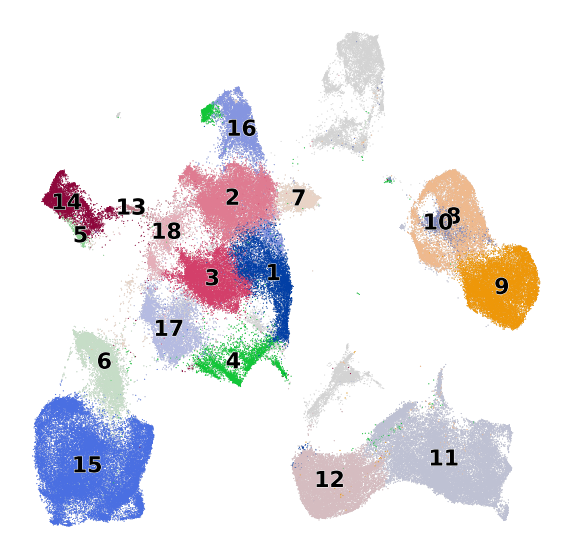

In [193]:
high_q_numbers = adata.obs['anno_number'][adata.obs['anno_lvl_2_final_clean'].isin(anno_order)].unique().astype("str")

plt.rcParams['figure.figsize'] = [10,10]
scv.pl.umap(adata, color=['anno_number'], 
            title="", legend_fontsize=22, size=5,
            groups=high_q_numbers,
            save='{s}_annotation_embedding.png'.format(s=split)
           )

Make legend

In [194]:
color_dict = dict(zip(adata.obs['anno_number'].cat.categories, adata.uns['anno_number_colors']))
anno_order_labels = ["({n}) {a}".format(n=str(i+1),a=anno_order[i]) for i in range(len(anno_order))]
anno_number = ["{n}".format(n=str(i+1)) for i in range(len(anno_order))]

anno_order_df = pd.DataFrame([anno_order_labels, anno_order]).T
anno_order_df.columns = ['anno_order_labels', 'anno_lvl_2_final_clean']
anno_order_df['anno_number'] = [anno_numbering[x] for x in anno_order_df['anno_lvl_2_final_clean']]
anno_order_df['anno_color'] = [color_dict[x] for x in anno_order_df['anno_number']]
anno_order_df['anno_group'] = split

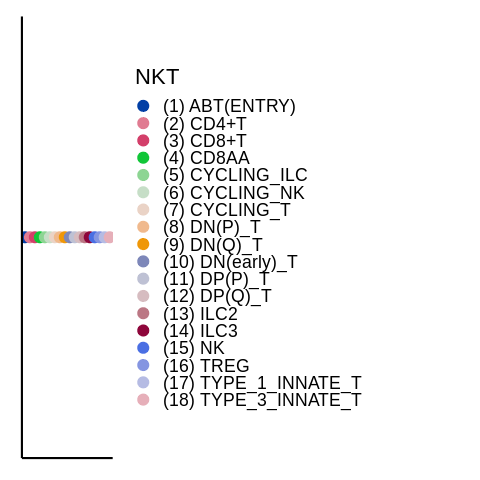

In [195]:
%%R -i anno_order_df 
library(ggpubr)
anno_order_df$anno_order_labels <- factor(anno_order_df$anno_order_labels, levels=anno_order_df$anno_order_labels)
leg_ls <- lapply(unique(anno_order_df$anno_group), function(g) {
    pl <- anno_order_df %>%
    filter(anno_group==g) %>%
    ggplot(aes(anno_order_labels, 1, color=anno_order_labels)) +
    geom_point(size=5) +
    theme_classic(base_size=22) +
    remove_x_axis() +
    remove_y_axis() +
    scale_color_manual(values=setNames(anno_order_df$anno_color, anno_order_df$anno_order_labels),
                      name=g)
#     leg <- get_legend(pl)
#     leg
    pl
    }
)

(wrap_plots(leg_ls, ncol=2) +
plot_layout(guides='collect') & 
theme(legend.justification = "left") &
guides(color=guide_legend(ncol = 1))) +
ggsave(paste0(figdir, "nkt_embedding_legend.pdf"), height=14, width=12)

#### Erythroid/mk cells

In [27]:
split="MEM_PROGENITORS"

In [28]:
adata = sc.read_h5ad(data_dir + 'PAN.A01.v01.entire_data_normalised_log.{t}.{s}.embedding.h5ad'.format(t=timestamp, s=split), backed="r")
adata.var_names_make_unique()

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [29]:
anno_obs = pd.read_csv(data_dir + "PAN.A01.v01.entire_data_normalised_log.20210429.full_obs.annotated.clean.csv", index_col=0)
anno_obs_lym = anno_obs.loc[adata.obs_names[adata.obs_names.isin(anno_obs.index)]].copy()

In [33]:
anno_groups_dict['ERYTHROID CELLS']

['EARLY_ERY', 'EARLY_MK', 'PROMYELOCYTE', 'MID_ERY', 'LATE_ERY', 'LATE_MK']

In [47]:
anno_groups_ery = {
    "ERYTHROID":['MEMP', "CYCLING_MEMP","MEP", 'EARLY_ERY',  'MID_ERY', 'LATE_ERY', 'YS_ERY', "CYCLING_YS_ERY",'EARLY_MK','LATE_MK', 
                 "VSMC_PERICYTE_III", "MACROPHAGE_ERY"],
    "OTHER":[x for x in anno_obs_lym.anno_lvl_2_final_clean.unique() if x in anno_groups_dict['OTHER']]
}

In [48]:
anno_obs = anno_obs_lym.copy()
anno_order = sum([v for v in anno_groups_ery.values()], [])
# keep_annos = 
anno_group = {split:anno_order}

In [49]:
adata.obs['anno_lvl_2_final_clean'] = np.nan
adata.obs.loc[adata.obs_names.isin(anno_obs_lym.index), 'anno_lvl_2_final_clean'] = anno_obs_lym.loc[adata.obs_names[adata.obs_names.isin(anno_obs_lym.index)]]['anno_lvl_2_final_clean']

In [50]:
anno_numbering = {anno_order[i]:str(i+1) for i in range(len(anno_order))}
adata.obs['anno_number'] = [anno_numbering[x] if x in anno_order else np.nan for x in adata.obs['anno_lvl_2_final_clean']]

saving figure to file /home/jovyan/mount/gdrive/Pan_fetal/writing/ms_figures/draft_panels/assemble_fig2/scvelo_MEM_PROGENITORS_annotation_embedding.png


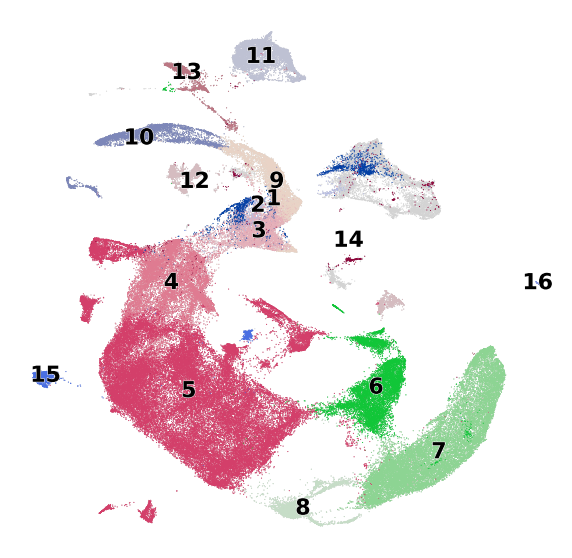

In [51]:
high_q_numbers = adata.obs['anno_number'][adata.obs['anno_lvl_2_final_clean'].isin(anno_order)].unique().astype("str")

plt.rcParams['figure.figsize'] = [10,10]
scv.pl.umap(adata, color=['anno_number'], 
            title="", legend_fontsize=22, size=5,
            groups=high_q_numbers,
            save='{s}_annotation_embedding.png'.format(s=split)
           )

Make legend

In [52]:
color_dict = dict(zip(adata.obs['anno_number'].cat.categories, adata.uns['anno_number_colors']))
anno_order_labels = ["({n}) {a}".format(n=str(i+1),a=anno_order[i]) for i in range(len(anno_order))]
anno_number = ["{n}".format(n=str(i+1)) for i in range(len(anno_order))]

anno_order_df = pd.DataFrame([anno_order_labels, anno_order]).T
anno_order_df.columns = ['anno_order_labels', 'anno_lvl_2_final_clean']
anno_order_df['anno_number'] = [anno_numbering[x] for x in anno_order_df['anno_lvl_2_final_clean']]
anno_order_df['anno_color'] = [color_dict[x] for x in anno_order_df['anno_number']]
anno_order_df['anno_group'] = split

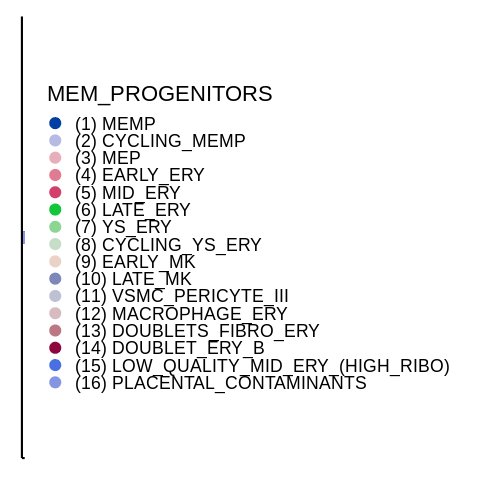

In [54]:
%%R -i anno_order_df -i figdir
library(ggpubr)
anno_order_df$anno_order_labels <- factor(anno_order_df$anno_order_labels, levels=anno_order_df$anno_order_labels)
leg_ls <- lapply(unique(anno_order_df$anno_group), function(g) {
    pl <- anno_order_df %>%
    filter(anno_group==g) %>%
    ggplot(aes(anno_order_labels, 1, color=anno_order_labels)) +
    geom_point(size=5) +
    theme_classic(base_size=22) +
    remove_x_axis() +
    remove_y_axis() +
    scale_color_manual(values=setNames(anno_order_df$anno_color, anno_order_df$anno_order_labels),
                      name=g)
#     leg <- get_legend(pl)
#     leg
    pl
    }
)

(wrap_plots(leg_ls, ncol=2) +
plot_layout(guides='collect') & 
theme(legend.justification = "left") &
guides(color=guide_legend(ncol = 1))) +
ggsave(paste0(figdir, "ery_embedding_legend.pdf"), height=14, width=12)

#### Stroma

In [150]:
split="STROMA"

In [151]:
adata = sc.read_h5ad(data_dir + 'PAN.A01.v01.entire_data_normalised_log.{t}.{s}.embedding.h5ad'.format(t=timestamp, s=split), backed="r")
adata.var_names_make_unique()

In [152]:
anno_obs = pd.read_csv(data_dir + "PAN.A01.v01.entire_data_normalised_log.20210429.full_obs.annotated.clean.csv", index_col=0)
anno_obs_lym = anno_obs.loc[adata.obs_names[adata.obs_names.isin(anno_obs.index)]].copy()

In [153]:
anno_obs = anno_obs_lym.copy()
anno_order = list(anno_obs_lym['anno_lvl_2_final_clean'].unique())
anno_order.sort()
anno_group = {split:anno_order}

In [154]:
adata.obs['anno_lvl_2_final_clean'] = np.nan
adata.obs.loc[adata.obs_names.isin(anno_obs_lym.index), 'anno_lvl_2_final_clean'] = anno_obs_lym.loc[adata.obs_names[adata.obs_names.isin(anno_obs_lym.index)]]['anno_lvl_2_final_clean']

In [155]:
anno_numbering = {anno_order[i]:str(i+1) for i in range(len(anno_order))}
adata.obs['anno_number'] = [anno_numbering[x] if x in anno_order else np.nan for x in adata.obs['anno_lvl_2_final_clean']]

saving figure to file /home/jovyan/mount/gdrive/Pan_fetal/writing/ms_figures/draft_panels/assemble_fig2/scvelo_STROMA_annotation_embedding.png


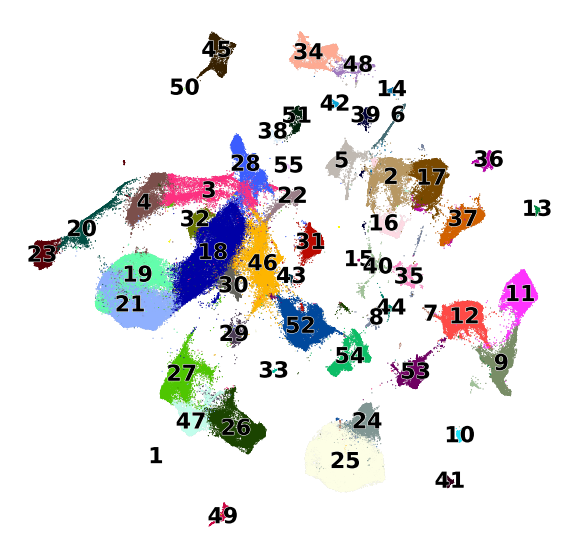

In [156]:
# high_q_numbers = adata.obs['anno_number'][~adata.obs['anno_lvl_2_final_clean'].isin(anno_group_lymphoid['low quality'])].unique().astype("str")

plt.rcParams['figure.figsize'] = [10,10]
scv.pl.umap(adata, color=['anno_number'], 
            title="", legend_fontsize=22, size=5,
#             groups=high_q_numbers,
            save='{s}_annotation_embedding.png'.format(s=split)
           )

Make legend

In [157]:
color_dict = dict(zip(adata.obs['anno_number'].cat.categories, adata.uns['anno_number_colors']))
anno_order_labels = ["({n}) {a}".format(n=str(i+1),a=anno_order[i]) for i in range(len(anno_order))]
anno_number = ["{n}".format(n=str(i+1)) for i in range(len(anno_order))]

anno_order_df = pd.DataFrame([anno_order_labels, anno_order]).T
anno_order_df.columns = ['anno_order_labels', 'anno_lvl_2_final_clean']
anno_order_df['anno_number'] = [anno_numbering[x] for x in anno_order_df['anno_lvl_2_final_clean']]
anno_order_df['anno_color'] = [color_dict[x] for x in anno_order_df['anno_number']]
anno_order_df['anno_group'] = split

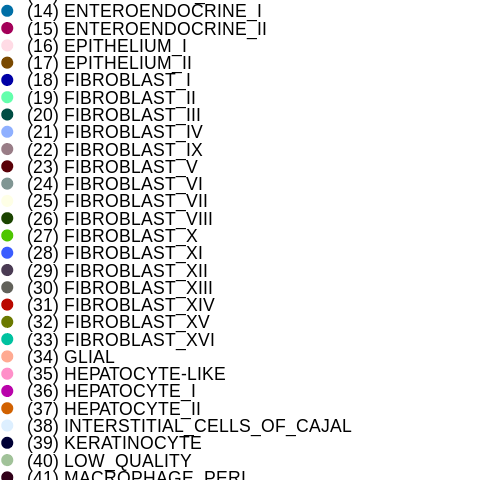

In [158]:
%%R -i anno_order_df 
library(ggpubr)
anno_order_df$anno_order_labels <- factor(anno_order_df$anno_order_labels, levels=anno_order_df$anno_order_labels)
leg_ls <- lapply(unique(anno_order_df$anno_group), function(g) {
    pl <- anno_order_df %>%
    filter(anno_group==g) %>%
    ggplot(aes(anno_order_labels, 1, color=anno_order_labels)) +
    geom_point(size=5) +
    theme_classic(base_size=22) +
    remove_x_axis() +
    remove_y_axis() +
    scale_color_manual(values=setNames(anno_order_df$anno_color, anno_order_df$anno_order_labels),
                      name=g)
#     leg <- get_legend(pl)
#     leg
    pl
    }
)

(wrap_plots(leg_ls, ncol=2) +
plot_layout(guides='collect') & 
theme(legend.justification = "left") &
guides(color=guide_legend(ncol = 1))) +
ggsave(paste0(figdir, "stroma_embedding_legend.pdf"), height=14, width=12)

### Organ / age distribution

In [641]:
anno_obs = anno_obs_lym.copy()
anno_group = anno_group_lymphoid.copy()
anno_group_rev = anno_group_lymphoid_rev.copy()

org_count_df = anno_obs_lym.groupby(["organ", "anno_lvl_2_final_clean"]).count()['file'].reset_index()
org_count_df["anno_group"] = [anno_group_rev[x] if x in anno_group_rev.keys() else np.nan for x in org_count_df.anno_lvl_2_final_clean]
org_count_df["anno"] = org_count_df["anno_lvl_2_final_clean"]

age_count_df = anno_obs_lym.groupby(["age", "anno_lvl_2_final_clean"]).count()['file'].reset_index()
age_count_df["anno_group"] = [anno_group_rev[x] if x in anno_group_rev.keys() else np.nan for x in age_count_df.anno_lvl_2_final_clean]
age_count_df["anno"] = age_count_df["anno_lvl_2_final_clean"]

anno_group_order = list(anno_group.keys())
anno_order = sum([v for v in anno_group.values()],[])
org_count_df

,organ,anno_lvl_2_final_clean,file,anno_group,anno
0,BM,ABT(ENTRY),2,Developing T cells,ABT(ENTRY)
1,BM,B1,97,B cells,B1
2,BM,CD4+T,255,Conventional SP T cells,CD4+T
3,BM,CD8+T,126,Conventional SP T cells,CD8+T
4,BM,CD8AA,15,Unconventional T cells,CD8AA
...,...,...,...,...,...
373,YS,NK_T,3,Unconventional T cells,NK_T
374,YS,PDC,18,NaN,PDC
375,YS,PRE_DC2,2,NaN,PRE_DC2
376,YS,PRE_PRO_B,50,B cells,PRE_PRO_B


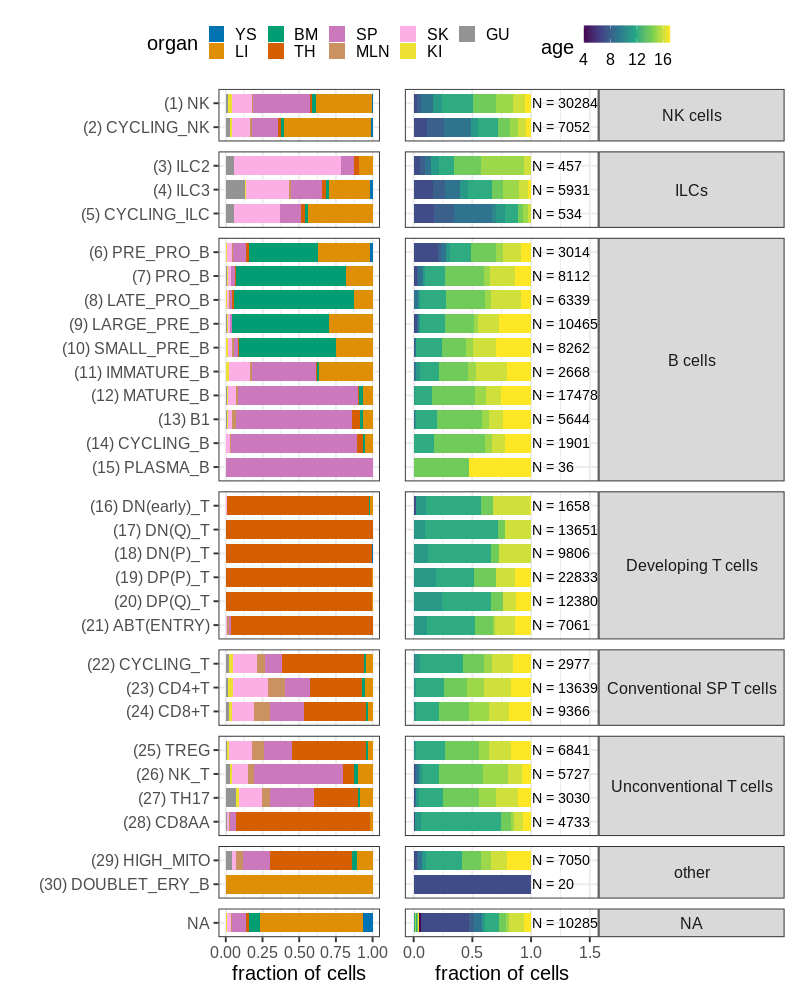

In [642]:
%%R -i age_count_df -i org_count_df -i figdir -i anno_group_order -i anno_order -i organ_order -w 800 -h 1000
library(glue)
anno_order_labels <- glue("({1:length(anno_order)}) {anno_order}")
anno_order_labels <- setNames(anno_order_labels, anno_order)

## Plot age barplot
age_pl_df <- age_count_df %>%
    rename(N_cells = file) %>%
    group_by(anno) %>%
    mutate(max_age = age[which.max(N_cells)])  %>% ## At which age there are most cells?
    mutate(min_age = min(age[which(N_cells > 10)]))  %>%
    ungroup() %>%
    arrange(- max_age) %>%
#     mutate(anno=factor(anno, levels=unique(anno))) %>%
    mutate(anno=anno_order_labels[anno]) %>%
    mutate(anno=factor(anno, levels=rev(anno_order_labels))) %>%
    mutate(anno_group = factor(anno_group, levels=anno_group_order))
    
p2 <- age_pl_df %>%
    filter(N_cells > 10) %>%
    ggplot(aes(anno, N_cells)) + 
    geom_col(aes(fill=age),position="fill", width=0.8) +
    coord_flip() +
    facet_grid(anno_group~., space="free", scales="free") +
    scale_fill_viridis_c() +
    theme_bw(base_size=20) +
    theme(strip.text.y=element_text(angle=0)) +
    ylab("fraction of cells") + xlab("") +
    expand_limits(y = 1.5) +
    geom_text(data=. %>% group_by(anno) %>% 
              summarise(N_cells=sum(N_cells), anno_group=first(anno_group)),
              hjust=0, size=5,
              y=1.01, aes(label=paste("N =", N_cells))
             ) 

## Plot organ barplot
org_palette <- setNames(org_colors$color, rownames(org_colors))
org_pl_df <- org_count_df %>%
    rename(N_cells = file) %>%
    mutate(anno=anno_order_labels[anno]) %>%
    mutate(anno=factor(anno, levels=levels(age_pl_df$anno))) %>%
    mutate(anno_group = factor(anno_group, levels=anno_group_order))

p1 <- org_pl_df %>%
    filter(N_cells > 10) %>%
    mutate(organ=factor(organ, levels=organ_order)) %>%
    ggplot(aes(anno, N_cells)) + 
    geom_col(aes(fill=organ) ,position="fill", width=0.8) +
    coord_flip() +
    facet_grid(anno_group~., space="free", scales="free") +
    scale_fill_manual(values=org_palette) +
    theme_bw(base_size=20) +
    theme(strip.text.y=element_text(angle=0)) +
    ylab("fraction of cells") + xlab("") +
    theme(strip.background=element_blank(), strip.text.y = element_blank())
#     geom_text(data=. %>% group_by(anno) %>% 
#               summarise(N_cells=sum(N_cells), anno_group=first(anno_group)),
#               hjust=0,
#               y=1.01, aes(label=paste("N =", N_cells))
#              ) +

fig2_lym_barplots <- (p1 + (p2 + remove_y_axis())) +
plot_layout(widths=c(1,1.2), guides="collect") &
# (guides(fill = guide_colourbar(title.position="top", title.hjust = 0.5))) &
(theme(legend.position="top"))

fig2_lym_barplots +
    ggsave(paste0(figdir, "lym_organ_age_distribution.pdf"), height=12, width=12) +
    ggsave(paste0(figdir, "lym_organ_age_distribution.png"), height=12, width=12) 

### Milo in time beeswarm plot

In [281]:
lym_milo_time.anno_group = [anno_group_rev[x] if x in anno_order else 'NA' for x in lym_milo_time.nhood_anno]

In [282]:
%%R -w 1200 -h 600 -i figdir -i lym_milo_time -i anno_order -i anno_group_order
library(ggbeeswarm)
alpha=0.1
set.seed(12345)

lym_milo_time <- lym_milo_time %>%
    ## Reorder annotation names by median FC
    group_by(nhood_anno) %>%
    mutate(mean_logFC = median(logFC, na.rm=TRUE)) %>%
    ungroup() %>%
    arrange(- mean_logFC) %>%
    mutate(nhood_anno=factor(nhood_anno, levels=rev(anno_order))) %>%
    ## Calculate median per organ, to plot
    group_by(organ, nhood_anno) %>%
    mutate(mean_logFC = median(logFC, na.rm=TRUE)) %>%
    ungroup() %>%
    mutate(anno_group=factor(anno_group, levels=anno_group_order)) %>%
    mutate(organ=factor(organ, levels=organ_order)) %>%
    filter(!is.na(anno_group)) 

fig2_lym_beeswarm <- lym_milo_time %>%
    mutate(organ_color=ifelse(SpatialFDR < alpha, as.character(organ), NA)) %>%
    ggplot(aes(nhood_anno, logFC)) +
    geom_quasirandom(data=. %>% filter(SpatialFDR >= alpha),size=0.3, color="grey") +
    geom_quasirandom(data=. %>% filter(SpatialFDR < alpha), size=0.5, aes(color=organ_color)) +    geom_point(data= . %>% distinct(organ, nhood_anno, anno_group, mean_logFC), aes(x=nhood_anno, y=mean_logFC), color="black")  +
    facet_grid(anno_group~organ, scales="free", space="free_y") +
    coord_flip() +
    scale_color_manual(values=org_palette) +
    scale_fill_manual(values=org_palette) +
    guides(color="none", fill="none") +
    geom_hline(yintercept=0, linetype=2) +
    theme_bw(base_size=18) +
    xlab("") + ylab("log-Fold Change in time") +
    scale_y_continuous(breaks=seq(-3,3, by=1)) +
    theme(strip.text.y=element_text(angle=0))

#     ggsave(paste0(figdir, "milo_results_overview_beeswarm.pdf"), width=15, height=15) +
#     ggsave(paste0(figdir, "milo_results_overview_beeswarm.png"), width=15, height=15)

In [283]:
org_age_range  = anno_obs[['organ', "age"]].drop_duplicates()

In [284]:
%%R -i org_age_range -w 1000 -h 200 -i organ_order
fig2_lym_agebar <- org_age_range %>%
    filter(organ %in% mye_milo_time$organ) %>%
    mutate(organ=factor(organ, levels=organ_order)) %>%
    group_by(organ) %>%
    mutate(max_age=paste0(max(age), " PCW"), 
           min_age=paste0(min(age), " PCW")) %>%
    mutate(y=1) %>%
    ggplot(aes( age, y, color=organ)) +
    geom_point(size=3) +
    geom_line(size=2) +
    geom_text(data=. %>% group_by(organ) %>% filter(age==min(age)), 
              aes(label=min_age), angle=45,
              vjust = 1.2, 
              hjust = 1.1, nudge_x = -0.05, color='black') +
    geom_text(data=. %>% group_by(organ) %>% filter(age==max(age)), 
              aes(label=max_age), angle=45,
              vjust = 1.2,  
              hjust = 1.1, nudge_x = -0.05, color='black') +
    facet_grid(.~organ) +
    scale_color_manual(values=org_palette) +
    theme_classic(base_size=18) +
     expand_limits(x = c(3,20)) +
    remove_y_axis() + remove_x_axis() + 
    guides(color='none') +
    xlab("") + ylab("log-Fold Change in time") +
    theme(strip.text.y=element_text(angle=0), axis.line=element_blank(), 
          strip.background=element_blank(), strip.text=element_blank())

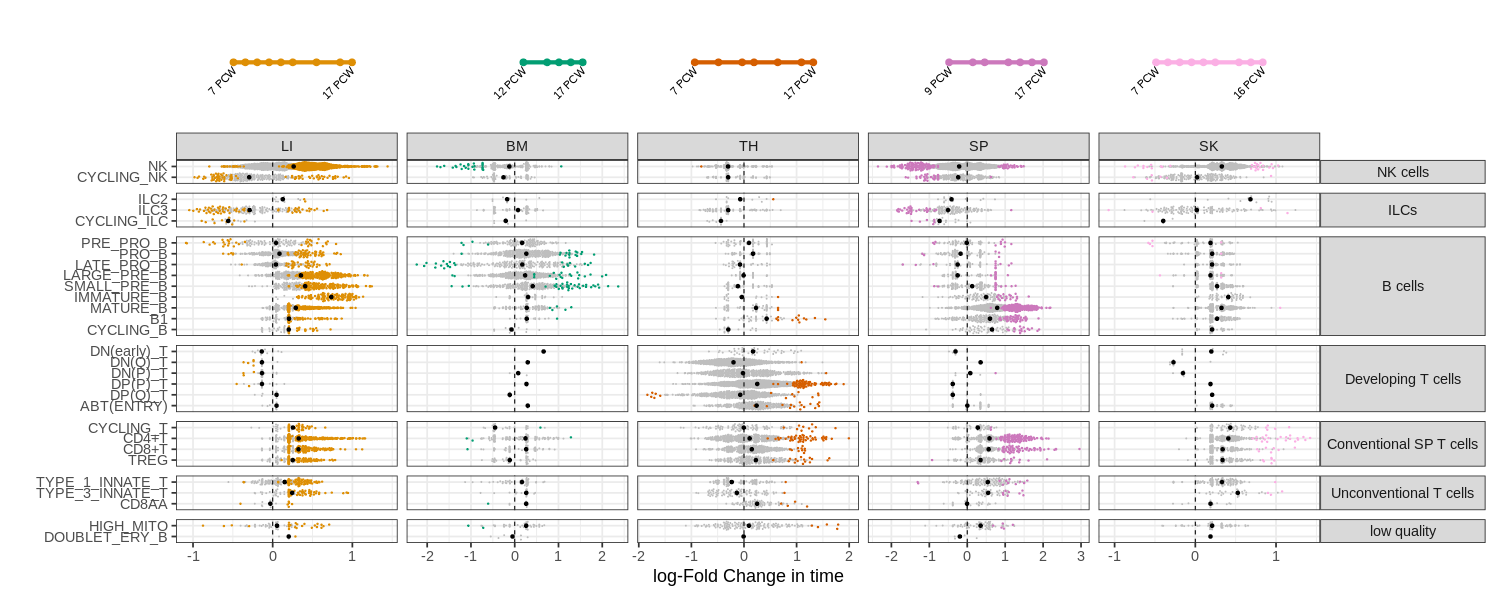

In [285]:
%%R -w 1500 -h 600
layout <- "
AAAAA
BBBBB
BBBBB
BBBBB
BBBBB
"

fig2_milo_age  <- fig2_lym_agebar + 
    fig2_lym_beeswarm +
    plot_layout(design=layout) 

fig2_milo_age +
ggsave(paste0(figdir, "milo_results_overview_beeswarm_lymphoid.pdf"), width=14, height=10) 


### Adult vs fetal

In [286]:
anno_group_rev = anno_group_lymphoid_rev.copy()

In [316]:
q_df = lym_adult_heatmap.copy()

query_anno_group_lymphoid = {'B cells': [
      'ABCs',
  'GC_B (I)',
  'GC_B (II)',
      'Plasma cells',
  'Plasmablasts',
    'Memory B cells',
  'Naive B cells',
  'Pro-B',
  'Pre-B'],
 'Innate lymphoid cells': ['ILC3', 'NK_CD16+', 'NK_CD56bright_CD16-'],
 'Conventional T cells': [
       'Tnaive/CM_CD8',
  'Trm/em_CD8',
  'Tem/emra_CD8',
  'Trm_gut_CD8',
  'Tnaive/CM_CD4',
    'Tnaive/CM_CD4_activated',
  'Teffector/EM_CD4',
  'Tgd_CRTAM+',
  'Trm_Tgd',
  'Tregs',
       'Cycling T&NK'
 ], 
    'Unconventional T cells': ['Tfh', 'MAIT','Trm_Th1/Th17'],
                             'other':['Cycling', 'Progenitor', 'DC2', 'Megakaryocytes', 'Classical monocytes',
       'Erythrophagocytic macrophages', 'Erythroid',
       'Intermediate macrophages', 'pDC']
}

query_anno_group_lymphoid_rev = {x:g for g,a in query_anno_group_lymphoid.items() for x in a}

q_df['annotation_query_group'] = [query_anno_group_lymphoid_rev[x] for x in q_df['annotation_query']]
q_df['predicted_anno_group'] = [anno_group_rev[x] if x in anno_order else 'low_confiden' if x=='low_confiden' else 'NA' for x in q_df['predicted_anno']]

query_anno_order = sum([x for x in query_anno_group_lymphoid.values()], [])

## Add lines for missing cell types
missing_anno_df = pd.DataFrame([x for x in anno_order if x not in q_df.predicted_anno.values], columns=['predicted_anno'])
q_df = pd.concat([q_df, missing_anno_df])

q_df['predicted_anno_group'] = [anno_group_rev[x] if x in anno_order else 'low_confiden' if x=='low_confiden' else 'NA' for x in q_df['predicted_anno']]


In [317]:
## Exclude rogue labels
keep_query_cts = q_df.annotation_query.value_counts().index[q_df.annotation_query.value_counts() > 10]

`summarise()` has grouped output by 'predicted_anno', 'annotation_query', 'annotation_query_group', 'predicted_anno_group'. You can override using the `.groups` argument.


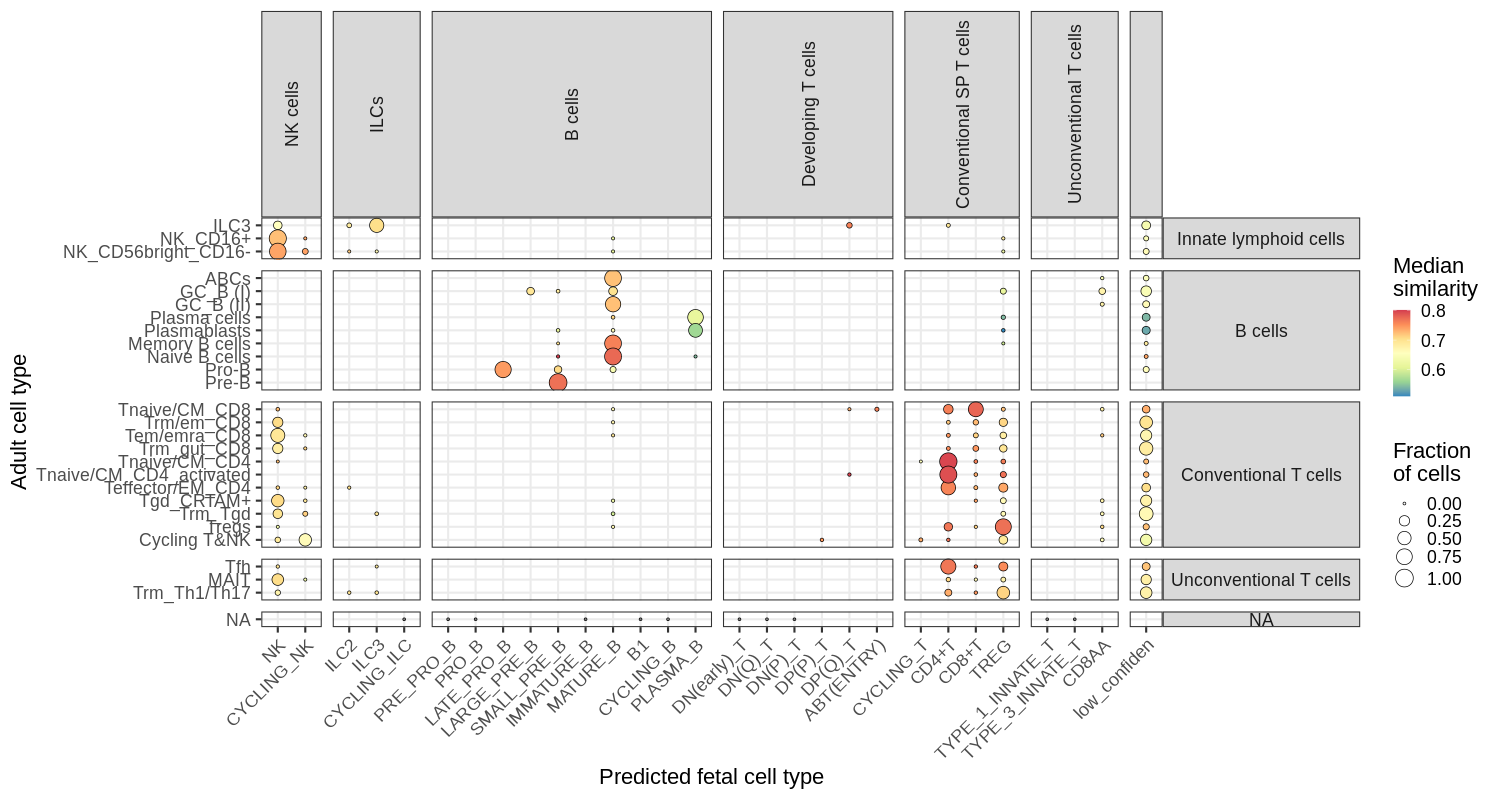

In [318]:
%%R -i q_df -h 800 -w 1500 -i figdir -i anno_order -i query_anno_order -i anno_group_order -i keep_query_cts
q_df %>%
    filter((annotation_query %in% keep_query_cts) | (is.na(annotation_query))) %>%
    group_by(annotation_query) %>%
    mutate(tot_cells=n()) %>%
    ungroup() %>%
    group_by(predicted_anno, annotation_query, annotation_query_group, predicted_anno_group) %>%
    summarise(frac_cells=n()/tot_cells, median_sim_score=median(min_distance2pred)) %>%
    ungroup() %>%
    filter(predicted_anno_group != 'low quality' & predicted_anno_group != 'NA') %>%
    mutate(annotation_query_group=factor(annotation_query_group, levels=c('Innate lymphoid cells',
                                                                          "B cells",
                                                                         'Conventional T cells',
                                                                         'Unconventional T cells')
                                                                        )) %>%
    mutate(predicted_anno_group = ifelse(predicted_anno_group=="low_confiden", '', predicted_anno_group)) %>%
    mutate(predicted_anno_group=factor(predicted_anno_group, levels=c(anno_group_order, ''))) %>%
    mutate(annotation_query=factor(annotation_query, levels=rev(query_anno_order))) %>%
    mutate(predicted_anno=factor(predicted_anno, levels=c(anno_order, 'low_confiden'))) %>%
    distinct() %>%
    mutate(frac_cells = ifelse(is.na(annotation_query), 0, frac_cells)) %>%
   ggplot(aes(predicted_anno, annotation_query)) +
    scale_size(range=c(1,8), name="Fraction\nof cells") +
    geom_point(aes(size=frac_cells, fill=median_sim_score), shape=21) +
    scale_fill_distiller(palette="Spectral", direction=-1, name='Median\nsimilarity',
                        ) +
#     scale_fill_viridis_c(option='magma', name='Median\nsimilarity') +
    facet_grid(annotation_query_group~predicted_anno_group, space="free", scales='free') +
    xlab("Predicted fetal cell type") + ylab("Adult cell type") +
    theme_bw(base_size=22) +
    theme(axis.text.x=element_text(angle=45, hjust=1),
          strip.text.y=element_text(angle=0), strip.text.x=element_text(angle=90)
         ) +
    ggsave(paste0(figdir, "adult_confusion_similarity_dotplot_lym.pdf"), width=18, height=15)